In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp
import itertools

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import pair_plot as pplt

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 2) Multivariate pdf: with Rosemblat and couplas
## Only one output or quantity of interest (QoI)

ISHIGAMI FUNCTION

Description: $ y = \sin(x_1) + a\,\sin^2(x_2) + b\,x_3^4 \,\sin(x_1) $

Dimensions: 3 

The Ishigami function of Ishigami & Homma (1990) is used as an example for uncertainty and sensitivity analysis methods, because it exhibits strong nonlinearity and nonmonotonicity. It also has a peculiar dependence on x3, as described by Sobol' & Levitan (1999). 

The values of a and b used by Crestaux et al. (2007) and Marrel et al. (2009) are: a = 7 and b = 0.1. Sobol' & Levitan (1999) use a = 7 and b = 0.05. 


In [2]:
def ishigami(a,b,wd,ws,s_ws):
    
    x1 = ws
    x2 = wd
    x3 = s_ws/10.
    
    term1 = np.sin(x1)
    term2 = a*(np.sin(x2))**2
    term3 = b*x3**4. * np.sin(x1)

    return term1 + term2 + term3

a = 7.
b = 0.1#0.8#

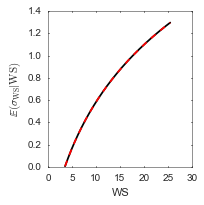

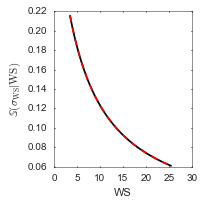

In [3]:
WS_rng = np.linspace(3.5,25.5,1000,endpoint=True)
I_ref = .16
S_sigma = (np.log( 1. + (1.4)**2./(0.75*WS_rng + 3.8)**2.))**0.5
E_sigma = np.log( I_ref*(0.75*WS_rng + 3.8) ) - S_sigma**2./2

E_sigma_pfit = np.poly1d(np.polyfit(WS_rng,E_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,E_sigma,'k')
ax.plot(WS_rng,E_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{E}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

S_sigma_pfit = np.poly1d(np.polyfit(WS_rng,S_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,S_sigma,'k')
ax.plot(WS_rng,S_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{S}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

In [4]:
dist_wd = cp.Uniform(-np.pi,np.pi)
dist_ws = cp.Weibull(shape=2., scale=8.)
dist_sigma_ws = cp.Lognormal(mu=E_sigma_pfit(dist_ws), sigma=S_sigma_pfit(dist_ws))

dist_X = cp.J(dist_wd,dist_ws,dist_sigma_ws)
dist_U = cp.J(cp.Uniform(),cp.Uniform(),cp.Uniform())


### a) MC with Halton sampling

In [5]:
N_MC=int(1e5)
sample_inputs = dist_X.sample(size=N_MC,rule='H')
sample_u = np.array([ishigami(a,b,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

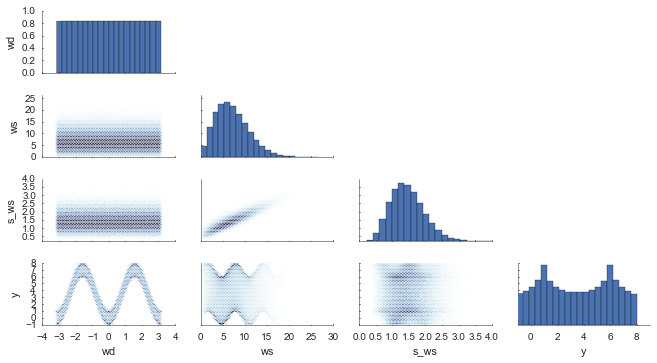

In [6]:
df_MC = pd.DataFrame(columns=['wd','ws','s_ws','y'],data=np.vstack([sample_inputs,sample_u]).T)
g=sns.PairGrid(df_MC,size=1.3,aspect=1.8,diag_sharey=False)
#g.map_lower(plt.scatter,alpha=0.2)
g.map_lower(plt.hexbin, gridsize=40, color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15, as_cmap=True))
g.map_diag(plt.hist,bins=20) 
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False) 
g.savefig('Figures/2b_Ishigami_MC_sample.pdf')

# Point collocation

In [7]:
D = 3    # Number fo dimensions
M = 8    # Order of the polynomial
N = M + 1 # Number of terms

P = cp.orth_ttr(M,dist_U)

In [8]:
# Fixed number of model evaluations and Hammersley sequence sampling
nodes_U = dist_U.sample(3*special.comb(D+M,M),rule='L')
#nodes_U = dist_U.sample(150,rule='M')

print('nodes', len(nodes_U[0,:]))

nodes_X = dist_X.inv(dist_U.fwd(nodes_U))
sample_u_pc = np.array([ishigami(a,b,*node) for node in nodes_X.T])

nodes 495


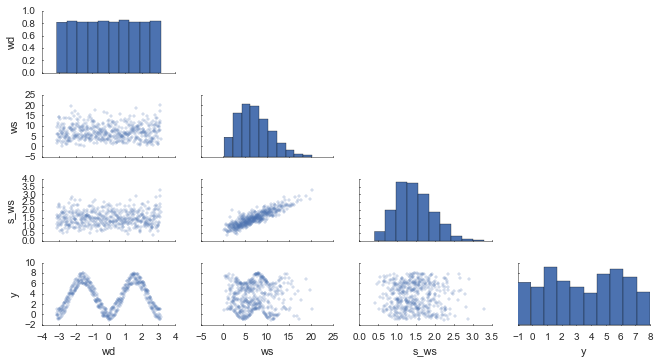

In [9]:
df_train=pd.DataFrame(columns=['wd','ws','s_ws','y'],data=np.vstack([nodes_X,sample_u_pc]).T)
g=sns.PairGrid(df_train,size=1.3,aspect=1.8,diag_sharey=False)
g.map_lower(plt.scatter,alpha=0.8,marker='+')
#g.map_lower(plt.hexbin, gridsize=40, color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15, as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist) 
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.savefig('Figures/2b_Ishigami_PCE_nodes.pdf')

In [11]:
# Point collocation
u_hat = cp.fit_regression(P, nodes_U, sample_u_pc, 
                          #rule='LA',n_nonzero_coefs=300) #Lars (Least Angle Regression). n_nonzero_coefs= all dimensions
                          #rule='LAS',alpha=1e-4,max_iter=200) #Lasso (Least Absolute Shrinkage and Selection Operator) 
                          rule='LL', alpha=1e-6,max_iter=200) #Lasso and Lars model
                          #rule='OMP',n_nonzero_coefs=50, tol=4e1) # Orthogonal Matching Pursuit. n_nonzero_coefs=1D
                          #)

# Statistics based on the PCE coefficients
mean_u_pc, std_u_pc = cp.E(u_hat, dist_U), cp.Std(u_hat, dist_U)

print(len(u_hat.expons()))
        

94


In [12]:
# Repeat the MC sample ussing the surrogate model
sample_U_inputs = dist_U.sample(size=N_MC,rule='H')
sample_X_inputs = dist_X.inv(dist_U.fwd(sample_U_inputs))
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_U_inputs.T ])

E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

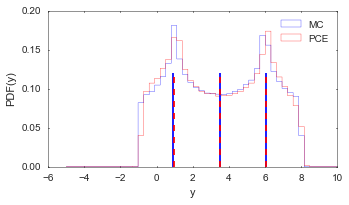

In [13]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=np.linspace(-5,10,50),
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,0.12,'blue')
#plt.vlines([Q05_u,Q95_u],0,0.12,'lightblue')

plt.hist(sample_u_hat,
         bins=np.linspace(-5,10,50),
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='PCE'
        )
plt.vlines([mean_u_pc,mean_u_pc-std_u_pc,mean_u_pc+std_u_pc],0,0.12,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,0.12,'pink')

ax.set_xlabel('y')
ax.set_ylabel('PDF(y)')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/2b_Ishigami_PCE_y.pdf')
print()

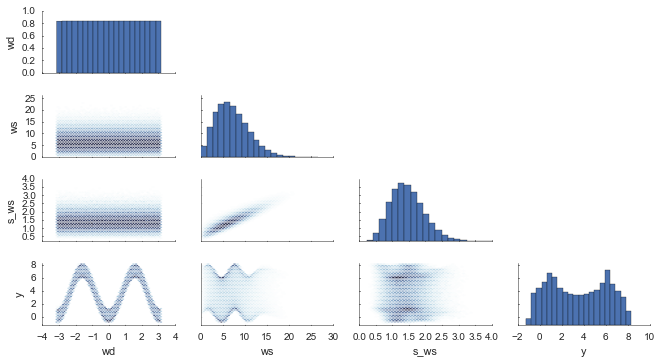

In [14]:
df_u_hat = pd.DataFrame(columns=['wd','ws','s_ws','y'],data=np.vstack([sample_X_inputs,sample_u_hat]).T)
g=sns.PairGrid(df_u_hat,size=1.3,aspect=1.8,diag_sharey=False)
#g.map_lower(plt.scatter,alpha=0.2)
g.map_lower(plt.hexbin, gridsize=40, color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15, as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist,bins=20) 
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.savefig('Figures/2b_Ishigami_PCE_sample.pdf')

In [15]:
var_list = ['wd','ws','s_ws','y']
var_labels = {'wd':'wd [rad.]','ws':'ws [m/s]','s_ws':r'$\sigma_{ws}$ [m/s]','y':'y'}
var_lims = {'wd':[-3.2,3.2],'ws':[0.,25],'s_ws':[0.,4.0],'y':[-2,9]}

/Users/JPM/OpenMDAO/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


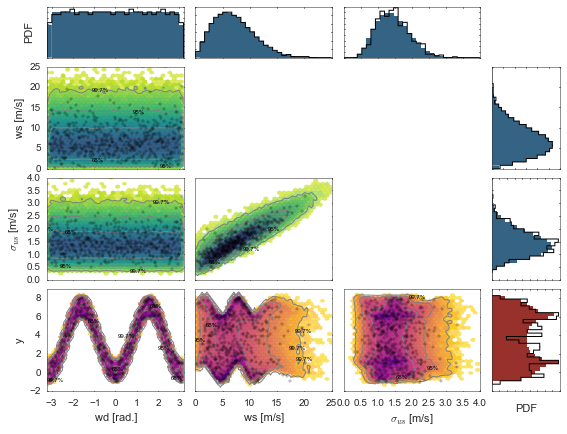

In [16]:
fig,ax= pplt.pair_plot(df_u_hat, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[8, 6])
fig,ax= pplt.pair_plot(df_train, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       marker='+',num_inputs=3, bins=30, alpha=0.8, 
                       colors='black', opt='scatter', fig=fig,ax=ax, figsize=[6, 6])
fig.savefig('Figures/2b_Ishigami_PCE_sample_train.png',dpi=400)

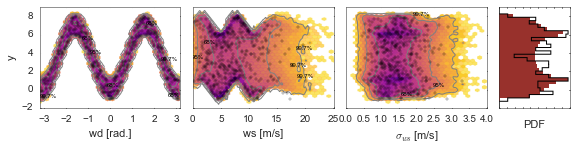

In [17]:
fig,ax= pplt.pair_plot_last_row(df_u_hat, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[8, 2], xlabels=True)
fig,ax= pplt.pair_plot_last_row(df_train, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       marker='+',num_inputs=3, bins=30, alpha=0.8, 
                       colors='black', opt='scatter', fig=fig,ax=ax, xlabels=True)
fig.savefig('Figures/2b_Ishigami_PCE_sample_train_last_row.png',dpi=400)

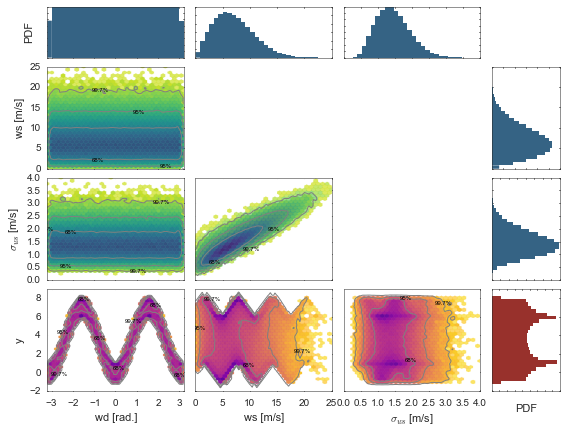

In [18]:
fig,ax= pplt.pair_plot(df_MC, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[8, 6])
#fig,ax= pplt.pair_plot(df_train, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
#                       marker='+',num_inputs=3, bins=30, alpha=0.8, 
#                       colors='black', opt='scatter', fig=fig,ax=ax, figsize=[6, 6])
fig.savefig('Figures/2b_Ishigami_MC_sample_train.png',dpi=400)

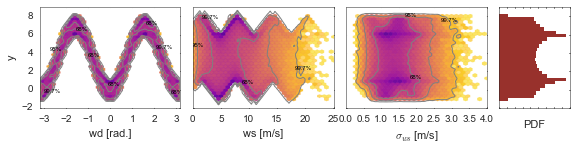

In [19]:
fig,ax= pplt.pair_plot_last_row(df_MC, var_list=var_list, var_lims=var_lims, var_labels=var_labels,
                       num_inputs=3, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[8,2],xlabels=True)
fig.savefig('Figures/2b_Ishigami_MC_sample_train_last_row.png',dpi=400)

In [20]:
S_m, S_t = cp.Sens_m(u_hat, dist_U), cp.Sens_t(u_hat, dist_U)

In [21]:
S_m

array([  9.29643197e-01,   6.89763530e-02,   3.35719910e-05])

In [23]:
S_t

array([ 0.93051881,  0.07019413,  0.00101675])